<a href="https://colab.research.google.com/github/benon33/w207-final/blob/main/Aastha_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
#import libraries
%matplotlib inline

import urllib.request as urllib2 # For python3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# For cleaning data
!pip install tweet-preprocessor
import preprocessor as p

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [36]:
train_data =  pd.read_csv('/train.csv')
test_data =  pd.read_csv('/test.csv')

features:

- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [37]:
# Shape of data
print(train_data.shape[0], train_data.shape[1])

7613 5


In [38]:
# Thoughts on breaking down hashtags and tags into their own features? Might be useful
# Found this article that does it: https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e
train_data['hashtag'] = train_data['text'].apply(lambda s: re.findall(r'#(\w+)', s))
test_data['hashtag'] = train_data['text'].apply(lambda s: re.findall(r'#(\w+)', s))

train_data['mentions'] = train_data['text'].apply(lambda x: re.findall(r"@(\w+)", x))
test_data['mentions'] = train_data['text'].apply(lambda x: re.findall(r"@(\w+)", x))

train_data['links'] = train_data['text'].apply(lambda x: re.findall(r"http:\/\/(\w+)", x))
test_data['links'] = train_data['text'].apply(lambda x: re.findall(r"http:\/\/(\w+)", x))

train_data['retweet'] = train_data['text'].apply(lambda x: "rt" in x.lower().split())
test_data['retweet'] = train_data['text'].apply(lambda x: "rt" in x.lower().split())

train_data.mentions = train_data.mentions.apply(lambda y: 0 if len(y)==0 else 1)
test_data.mentions = test_data.mentions.apply(lambda y: 0 if len(y)==0 else 1)
train_data.hashtag = train_data.hashtag.apply(lambda y: 0 if len(y)==0 else 1)
test_data.hashtag = test_data.hashtag.apply(lambda y: 0 if len(y)==0 else 1)

train_data.links = train_data.links.apply(lambda y: 0 if len(y)==0 else 1)
test_data.links = test_data.links.apply(lambda y: 0 if len(y)==0 else 1)

train_data.retweet = train_data.retweet.apply(lambda y: 0 if y == False else 1)
test_data.retweet = test_data.retweet.apply(lambda y: 0 if y == False else 1)

# print(train_data[train_data.hashtag.astype(bool)])
# print(train_data[train_data.mentions.astype(bool)])

# TODO: Make a feature for retweets
# TODO: Make a feature for links

# Replace empty list with NANs


train_data

# for i,v in enumerate(train_data['text']):
#   train_data.loc[i,'text'] = p.clean(v)

# for i,v in enumerate(test_data['text']):
#   test_data.loc[i,'text'] = p.clean(v)

# dev_data = train_data[5000:]
# train_data = train_data[:5000]

# TODO: Actually break these sets down into shuffled sets + labels

,id,keyword,location,text,target,hashtag,mentions,links,retweet
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1,0,0,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,0,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0,0,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1,0,0,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,0,0,1,0
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,0,1,0,0
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,0,0,1,0
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,0,0,0,0


In [39]:
def is_empty_list(list):
  return list == []

# Head of data
print(train_data.head(5))
# NANs
print(train_data.isna().sum())
# It looks like location is an optional field, same with keyword

print("Number of tweets with hashtags: ", train_data.hashtag.sum())
print("Number of tweets with mentions: ", train_data.mentions.sum())
print("Number of tweets with links: ", train_data.links.sum())
print("Number of tweets with retweets: ", train_data.retweet.sum())

# print(train_data.mentions.sum())
# print(train_data.links.sum())
# print(train_data.retweets.sum())

# Get all the disaster tweets top keywords
print(train_data[train_data.target == 1].groupby(['keyword']).count().sort_values('id', ascending=False)['id'])
# Get all the non-disaster tweets top keyword
print(train_data[train_data.target == 0].groupby(['keyword']).count().sort_values('id', ascending=False)['id'])

# print(train_data[train_data.target == 0].groupby(['keyword']).size().reset_index(name='counts').sort_values('counts', ascending=False))

   id keyword location  ... mentions  links  retweet
0   1     NaN      NaN  ...        0      0        0
1   4     NaN      NaN  ...        0      0        0
2   5     NaN      NaN  ...        0      0        0
3   6     NaN      NaN  ...        0      0        0
4   7     NaN      NaN  ...        0      0        0

[5 rows x 9 columns]
id             0
keyword       61
location    2533
text           0
target         0
hashtag        0
mentions       0
links          0
retweet        0
dtype: int64
Number of tweets with hashtags:  1743
Number of tweets with mentions:  2009
Number of tweets with links:  3604
Number of tweets with retweets:  81
keyword
derailment     39
wreckage       39
outbreak       39
debris         37
oil%20spill    37
               ..
blazing         1
epicentre       1
body%20bag      1
electrocute     1
ruin            1
Name: id, Length: 220, dtype: int64
keyword
body%20bags          40
harm                 37
armageddon           37
wrecked              36
r

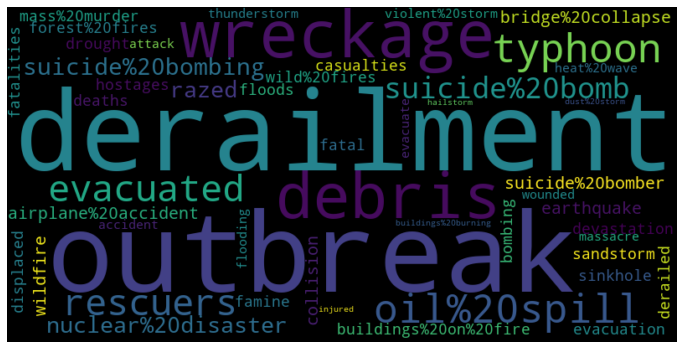

In [49]:
# Shows that keywords are not hashtags
# 0 & train_data.keyword.str.contains("body%20bags")]

from wordcloud import WordCloud
from nltk import word_tokenize, sent_tokenize, FreqDist
#Frequency of words
fdist_0 = FreqDist(train_data[train_data.target == 0]['keyword'])
fdist_1 = FreqDist(train_data[train_data.target == 1 & train_data.keyword.notna()]['keyword'])

#WordCloud
wc = WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(fdist_1)
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [41]:
train_data.groupby(['keyword']).count().sort_values('id', ascending=False)['id'].to_string()

'keyword\nfatalities               45\ndeluge                   42\narmageddon               42\nsinking                  41\ndamage                   41\nharm                     41\nbody%20bags              41\noutbreak                 40\nevacuate                 40\nfear                     40\ncollided                 40\nsiren                    40\ntwister                  40\nwindstorm                40\nsinkhole                 39\nsunk                     39\nhellfire                 39\nweapon                   39\nweapons                  39\nfamine                   39\nexplosion                39\nwhirlwind                39\nearthquake               39\nderailment               39\nwreckage                 39\ncollision                39\nflames                   39\nwrecked                  39\noil%20spill              38\nflooding                 38\ndeaths                   38\nderailed                 38\nthunder                  38\nambulance                38\ndrow

In [42]:
wc = WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(fdist_1)
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

TypeError: ignored